In [20]:
import numpy as np
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import csv
import cv2
import scipy
import os

In [11]:
num_classes = 4
epochs = 30
BASE_DIR = '/volumes/data/wht_bld_cell_clasfy/'
batch_size = 32

In [12]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(240, 320, 3), output_shape=(240, 320, 3))) #To get data in -1 to 1 range
    model.add(Conv2D(32, (3, 3), input_shape=(240, 320, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [13]:
def get_data(folder):
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):                  # To avoid hidden files and .ipython_checkpoint 
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [14]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [15]:
model = get_model()

model_checkpoint = ModelCheckpoint('training_balanced_weights.h5', monitor='val_loss', save_best_only=True)
early_s = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    
history = model.fit(
                    X_train,
                    y_train,
                    callbacks=[model_checkpoint,early_s],
                    validation_split=0.2,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size, verbose = 1)

model.load_weights('training_balanced_weights.h5')
model.save('training_balanced.h5')

Train on 7975 samples, validate on 1994 samples
Epoch 1/30
7975/7975 [==============================] - 50s - loss: 1.2570 - acc: 0.4046 - val_loss: 1.9132 - val_acc: 0.0000e+00
Epoch 2/30
7975/7975 [==============================] - 49s - loss: 0.9636 - acc: 0.5549 - val_loss: 3.2934 - val_acc: 0.0000e+00
Epoch 3/30
7975/7975 [==============================] - 49s - loss: 0.7244 - acc: 0.6913 - val_loss: 2.5679 - val_acc: 0.0863
Epoch 4/30
7975/7975 [==============================] - 50s - loss: 0.6052 - acc: 0.7656 - val_loss: 1.1557 - val_acc: 0.5491
Epoch 5/30
7975/7975 [==============================] - 49s - loss: 0.5308 - acc: 0.7851 - val_loss: 2.4120 - val_acc: 0.2533
Epoch 6/30
7975/7975 [==============================] - 50s - loss: 0.4919 - acc: 0.8088 - val_loss: 0.9245 - val_acc: 0.8250
Epoch 7/30
7975/7975 [==============================] - 49s - loss: 0.4642 - acc: 0.8260 - val_loss: 1.0541 - val_acc: 0.7136
Epoch 8/30
7975/7975 [==============================] - 49s - 

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()
    print('Last epoch train accuracy:', history.history['acc'][-1])
    print('Last epoch test accuracy:', history.history['val_acc'][-1])

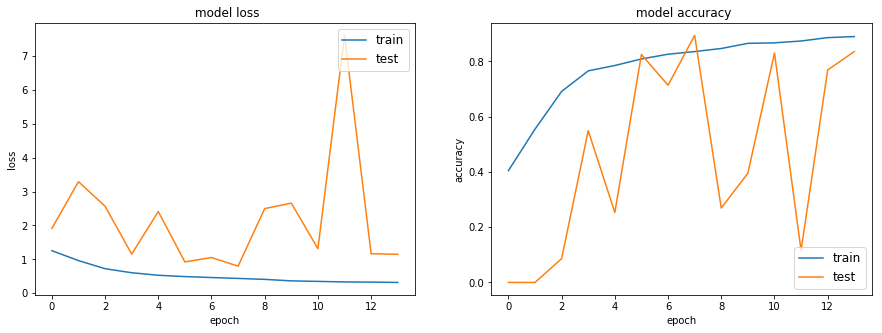

Last epoch train accuracy: 0.889780564263
Last epoch test accuracy: 0.835506519678


In [17]:
plot_history(history)

In [18]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [19]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')

print(accuracy_score(encoded_y_test, y_pred))

Predicting on test data
0.774647887324
